In [1]:
import sys
sys.path.append('/Users/aleksandr/Desktop/newGAN/glo-flow/')
sys.path

['/Users/aleksandr/Desktop/newGAN/glo-flow/notebooks',
 '/Users/aleksandr/miniconda/lib/python38.zip',
 '/Users/aleksandr/miniconda/lib/python3.8',
 '/Users/aleksandr/miniconda/lib/python3.8/lib-dynload',
 '',
 '/Users/aleksandr/miniconda/lib/python3.8/site-packages',
 '/Users/aleksandr/miniconda/lib/python3.8/site-packages/IPython/extensions',
 '/Users/aleksandr/.ipython',
 '/Users/aleksandr/Desktop/newGAN/glo-flow/']

In [2]:
from comet_ml import Experiment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

BW_METHOD = 0.1

In [ ]:
mnist = fetch_openml(name='mnist_784', version='active')

In [ ]:
pca = PCA(n_components=128)
data = pca.fit_transform(mnist.data)

In [4]:
data = data.T
data.shape

(128, 70000)

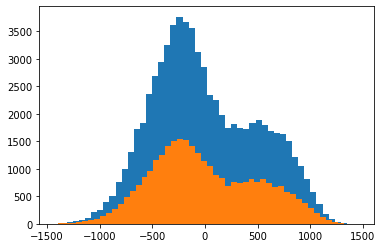

In [5]:
i = 1
plt.hist(data[i], bins=50)
kernel = gaussian_kde(data, bw_method=BW_METHOD)
sample = kernel.resample(30_000)
_ = plt.hist(sample[i], bins=50)

### Training the model

In [3]:
from modules.glo import GLOGenerator, GLOModel, SampleGenerator
from modules.train import GLOTrainer, visualize_image_grid
from modules.dataset import IdxDataset
from modules.validate import Validator

In [4]:
mnist_train = MNIST(root='../datasets', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = MNIST(root='../datasets', train=False, transform=transforms.ToTensor(), download=True)

In [5]:
mnist_train = IdxDataset(mnist_train)
mnist_test = IdxDataset(mnist_test)
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=32, shuffle=False)

In [6]:
res = next(iter(train_loader))
res[1].shape

torch.Size([32, 1, 28, 28])

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         noise_channels=128,
                         num_blocks=3,
                         dataloader=train_loader).to(device)
sample_generator = SampleGenerator(train_loader, z_dim=128, bw_method=BW_METHOD)
model = GLOModel(generator, train_loader, sample_generator).to(device)

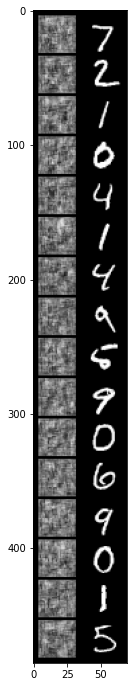

In [10]:
res = next(iter(test_loader))
grid = validator.visualize_val_results(z=sample_generator.generate_samples(16), img=res[1][:16])
plt.figure(figsize=(18, 12))
plt.imshow(grid)

In [9]:
init_z = nn.Parameter(torch.randn(size=(len(test_loader.dataset), 128), device=device, requires_grad=True))
optimizer = torch.optim.SGD([init_z], lr=1e2)
validator = Validator(model, test_loader, nn.L1Loss(), optimizer)
# validator.validate(min_loss=1, z=init_z)

In [9]:
experiment = Experiment(api_key='CfFmqDpTCtsdDkLooedZh7bs2',
                        project_name='glo-mnist',
                        workspace='alexandernevarko')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/alexandernevarko/glo-mnist/fc75687ebde7493ca2a4bdc25faad710



In [9]:
trainer = GLOTrainer(model, use_gpu=False, logger=experiment)

In [10]:
loss_func = nn.L1Loss()
optimizer = torch.optim.SGD([
    {'params': model.generator.parameters(), 'lr': 1e-3},
    {'params': model.z, 'lr': 1}
])

In [11]:
torch.sum(model.z[0]**2)

tensor(1., grad_fn=<SumBackward0>)

In [12]:
model.z

Parameter containing:
tensor([[-3.3755e-01,  3.1330e-01, -1.7731e-01,  ...,  1.4037e-04,
          1.2281e-02,  3.0320e-02],
        [-2.9786e-01,  4.6254e-01,  3.1886e-02,  ...,  9.4285e-03,
          9.0156e-03,  5.6341e-03],
        [ 9.5591e-02,  2.7813e-01, -4.0032e-01,  ...,  3.8151e-03,
         -3.3732e-02,  3.0918e-02],
        ...,
        [ 1.8333e-01,  1.5791e-01,  2.9805e-02,  ..., -1.8981e-02,
         -1.6791e-02,  2.7939e-02],
        [-1.3625e-01, -5.8471e-02,  1.1890e-01,  ...,  2.8830e-02,
         -3.3027e-02, -1.5449e-03],
        [ 1.9912e-01, -3.7841e-01, -1.3152e-01,  ..., -7.2910e-03,
         -1.4502e-02,  8.2203e-03]], requires_grad=True)

In [16]:
model.z

Parameter containing:
tensor([[-3.3878e-01,  3.1108e-01, -1.7770e-01,  ...,  1.3327e-04,
          1.0573e-02,  3.0073e-02],
        [-2.9746e-01,  4.5952e-01,  3.1052e-02,  ...,  1.2081e-02,
          9.1287e-03,  7.1439e-03],
        [ 9.5864e-02,  2.7947e-01, -4.0255e-01,  ...,  1.4511e-03,
         -3.4034e-02,  3.4174e-02],
        ...,
        [ 1.8333e-01,  1.5791e-01,  2.9805e-02,  ..., -1.8981e-02,
         -1.6791e-02,  2.7939e-02],
        [-1.3625e-01, -5.8471e-02,  1.1890e-01,  ...,  2.8830e-02,
         -3.3027e-02, -1.5449e-03],
        [ 1.9912e-01, -3.7841e-01, -1.3152e-01,  ..., -7.2910e-03,
         -1.4502e-02,  8.2203e-03]], requires_grad=True)

In [15]:
trainer.train(n_epochs=5, train_loader=train_loader, 
              loss_func=loss_func, optimizer=optimizer, exp_name='initial', model_path='m')

KeyboardInterrupt: 

In [23]:
a = torch.tensor([[1, 2, 3]]).T
b = torch.tensor([[0, 3, 5]]).T
torch.hstack([a, b])

tensor([[1, 0],
        [2, 3],
        [3, 5]])

In [22]:
a.long()

tensor([1, 2, 3])

In [10]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/glo-mnist/fc75687ebde7493ca2a4bdc25faad710
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (972 bytes)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 se